# ML Model Performance Evaluation

## 0 - Setup

In this section, we'll import all necessary libraries for data manipulation, model building, and evaluation metrics.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imblearn

import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.metrics import specificity_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

## 1 - Data Loading and Exploration

This notebook demonstrates the evaluation of machine learning models using various metrics, with a focus on a real-world mine detection problem. We'll explore how different evaluation metrics and probability thresholds affect model performance, with special attention to the cost of false negatives in safety-critical applications.

After a war, dangerous equipment often gets left behind scattered across fields. Over time, these items can become buried in the earth and lost to time. However, at some point later, civilians sometimes discover still-live explosives, leading to dangerous situations. Here in Flanders, for example, farmers still find live mines from WWI when plowing their fields to this day.

To combat this and remove as many dangerous items as possible, governments can take sonar scans of the ground. The dataset we are going to explore today contains a series of objects, each scanned 60 times with sonar from different angles. We are trying to predict whether a scanned object is an actual mine ('M') or a rock shaped like a mine ('R'). These values are stored in the 'Material' column.

**Real-world context**: This is a classic example of where the cost of false negatives (missing an actual mine) is much higher than false positives (incorrectly identifying a rock as a mine).

In [132]:
df = pd.read_csv("datasets/Sonar.csv")
df.head()

,Sonar1,Sonar2,Sonar3,Sonar4,Sonar5,Sonar6,Sonar7,Sonar8,Sonar9,Sonar10,...,Sonar52,Sonar53,Sonar54,Sonar55,Sonar56,Sonar57,Sonar58,Sonar59,Sonar60,Material
0,0.0664,0.0575,0.0842,0.0372,0.0458,0.0771,0.0771,0.1130,0.2353,0.1838,...,0.0141,0.0190,0.0043,0.0036,0.0026,0.0024,0.0162,0.0109,0.0079,R
1,0.0094,0.0333,0.0306,0.0376,0.1296,0.1795,0.1909,0.1692,0.1870,0.1725,...,0.0153,0.0112,0.0241,0.0164,0.0055,0.0078,0.0055,0.0091,0.0067,M
2,0.0201,0.0178,0.0274,0.0232,0.0724,0.0833,0.1232,0.1298,0.2085,0.2720,...,0.0131,0.0049,0.0104,0.0102,0.0092,0.0083,0.0020,0.0048,0.0036,M
3,0.0526,0.0563,0.1219,0.1206,0.0246,0.1022,0.0539,0.0439,0.2291,0.1632,...,0.0339,0.0149,0.0335,0.0376,0.0174,0.0132,0.0103,0.0364,0.0208,M
4,0.0261,0.0266,0.0223,0.0749,0.1364,0.1513,0.1316,0.1654,0.1864,0.2013,...,0.0222,0.0175,0.0127,0.0022,0.0124,0.0054,0.0021,0.0028,0.0023,M


## 2 - Data Processing

Before building our model, we need to split our data into training and testing sets.

In [133]:
X = df.drop(['Material'], axis=1)
y = df["Material"]

In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Print the shapes of our training and testing sets
print("Training set shape:", x_train.shape)
print("Testing set shape:", x_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

## 3 - Model Building

In this section, we'll build and optimize our Random Forest model using GridSearchCV. We focus on optimizing for recall since missing a mine (false negative) is more dangerous than incorrectly flagging a rock as a mine (false positive).

### Model Parameter Optimization with GridSearchCV

We'll use GridSearchCV to find the optimal parameters for our RandomForestClassifier. Since missing a mine (false negative) is more dangerous than incorrectly flagging a rock as a mine (false positive), we'll use recall as our optimization metric.

In [134]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the base model
rf_base = RandomForestClassifier(random_state=0)

# Initialize GridSearchCV
# We use recall as scoring metric since missing a mine is more costly than false alarms
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='recall',  # Using recall to minimize false negatives (missed mines)
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
grid_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best parameters found:")
print(grid_search.best_params_)
print("\nBest cross-validation recall score:", round(grid_search.best_score_, 3))

# Get the best model
best_rf_model = grid_search.best_estimator_

# Let's also look at other metrics for this model
print("\nDetailed cross-validation scores:")
cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = cv_results['rank_test_score'] == 1
print("\nMean test score:", round(cv_results.loc[best_idx, 'mean_test_score'].values[0], 3))
print("Standard deviation of test score:", round(cv_results.loc[best_idx, 'std_test_score'].values[0], 3))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best cross-validation recall score: nan

Detailed cross-validation scores:

Mean test score: nan
Standard deviation of test score: nan
Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best cross-validation recall score: nan

Detailed cross-validation scores:

Mean test score: nan
Standard deviation of test score: nan


c:\Users\billo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [135]:
# Use the best model found by GridSearchCV
ML_model = best_rf_model

# Make predictions on test set
y_pred_test = ML_model.predict(x_test)

# Get the probabilities for ROC curve
probs_test = pd.DataFrame(ML_model.predict_proba(x_test))
y_probs_test = probs_test.iloc[:,1]

# Print the classification report
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_test))

Classification Report for Best Model:
              precision    recall  f1-score   support

           M       0.84      0.82      0.83        33
           R       0.81      0.83      0.82        30

    accuracy                           0.83        63
   macro avg       0.83      0.83      0.83        63
weighted avg       0.83      0.83      0.83        63



In [136]:
y_pred=ML_model.predict(x_train)

probs = pd.DataFrame(ML_model.predict_proba(x_train))
y_probs = probs.iloc[:,1]

# Reset the index of y_train to ensure it aligns with the predictions
y_train_reset = y_train.reset_index(drop=True)

prediction_check = pd.DataFrame({'True label': y_train_reset,
                                'Predicted label': y_pred,
                                'Probabilities': y_probs})
prediction_check

,True label,Predicted label,Probabilities
0,R,R,0.94
1,M,M,0.18
2,M,M,0.01
3,R,R,0.94
4,M,M,0.18
...,...,...,...
140,M,M,0.23
141,R,R,0.75
142,M,M,0.09
143,M,M,0.23


In [137]:
# Test set predictions
y_pred_test = ML_model.predict(x_test)

probs_test = pd.DataFrame(ML_model.predict_proba(x_test))
y_probs_test = probs_test.iloc[:,1]

# Reset the index of y_test to ensure it aligns with the predictions
y_test_reset = y_test.reset_index(drop=True)

prediction_check_test = pd.DataFrame({'True label': y_test_reset,
                                      'Predicted label': y_pred_test,
                                      'Probabilities': y_probs_test})
prediction_check_test

,True label,Predicted label,Probabilities
0,M,M,0.32
1,M,M,0.15
2,M,M,0.37
3,M,M,0.24
4,M,M,0.15
...,...,...,...
58,R,R,0.51
59,M,M,0.16
60,M,M,0.50
61,M,M,0.43


## 4 - Evaluation

### Understanding Probability Thresholds

By default, classification models use a threshold of 0.5 to convert probabilities to predicted labels. However, we can adjust this threshold based on our needs:
- **Lower threshold** (e.g., 0.3): More sensitive, catches more mines but also flags more rocks as mines
- **Higher threshold** (e.g., 0.7): More specific, fewer false alarms but might miss some mines

For mine detection, missing an actual mine (false negative) is more dangerous than a false alarm (false positive), so we might want to use a lower threshold.

In [138]:
# Testing different probability thresholds

# Store results for each threshold
threshold_results = []

# thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# for threshold in thresholds_to_test:
for i in range(0, 101, 1):    
    threshold = i/100
    # Apply threshold to test set probabilities
    y_pred_custom = ['M' if prob >= threshold else 'R' for prob in y_probs_test]
    
    # Calculate metrics for this threshold
    # True Positives: Actual Mine, Predicted Mine
    tp = sum((y_test_reset == 'M') & (pd.Series(y_pred_custom) == 'M'))
    # False Positives: Actual Rock, Predicted Mine
    fp = sum((y_test_reset == 'R') & (pd.Series(y_pred_custom) == 'M'))
    # True Negatives: Actual Rock, Predicted Rock
    tn = sum((y_test_reset == 'R') & (pd.Series(y_pred_custom) == 'R'))
    # False Negatives: Actual Mine, Predicted Rock
    fn = sum((y_test_reset == 'M') & (pd.Series(y_pred_custom) == 'R'))
    
    # Calculate rates
    # True Positive Rate (Sensitivity/Recall)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    # False Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
       
    threshold_results.append({
        'Threshold': threshold,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'TPR (Recall)': round(tpr, 3),
        'FPR': round(fpr, 3),
        'Precision': round(precision, 3),
        'Accuracy': round(accuracy, 3)
    })

# Create DataFrame to display results
threshold_df = pd.DataFrame(threshold_results)
print("Impact of Different Probability Thresholds on Model Performance:")
print("="*80)
threshold_df

Impact of Different Probability Thresholds on Model Performance:


,Threshold,TP,FP,TN,FN,TPR (Recall),FPR,Precision,Accuracy
0,0.00,33,30,0,0,1.00,1.0,0.524,0.524
1,0.01,33,30,0,0,1.00,1.0,0.524,0.524
2,0.02,33,30,0,0,1.00,1.0,0.524,0.524
3,0.03,32,30,0,1,0.97,1.0,0.516,0.508
4,0.04,32,30,0,1,0.97,1.0,0.516,0.508
...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,30,33,0.00,0.0,0.000,0.476
97,0.97,0,0,30,33,0.00,0.0,0.000,0.476
98,0.98,0,0,30,33,0.00,0.0,0.000,0.476
99,0.99,0,0,30,33,0.00,0.0,0.000,0.476


Class ordering: ['M' 'R']


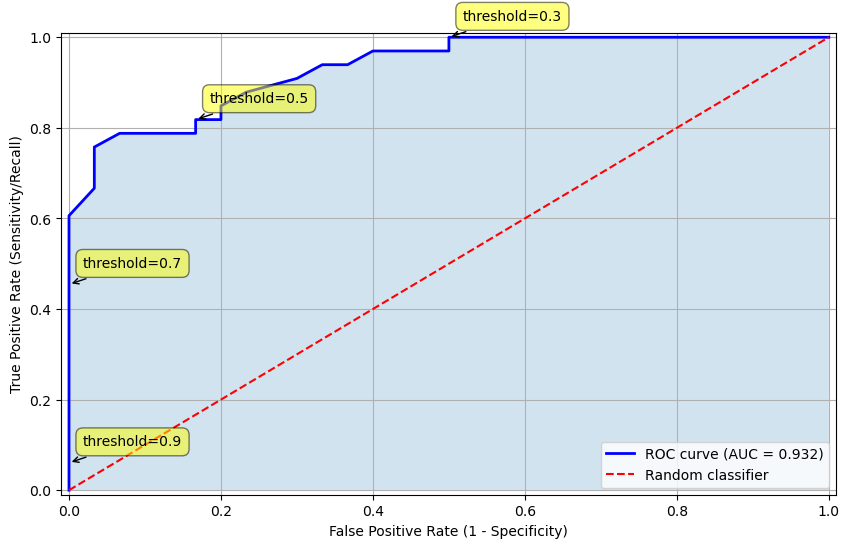


Detailed Performance Metrics:
AUC Score: 0.932

Performance at different thresholds:

At threshold 0.3:
True Positive Rate (Recall): 1.000
False Positive Rate: 0.500

At threshold 0.5:
True Positive Rate (Recall): 0.818
False Positive Rate: 0.167

At threshold 0.7:
True Positive Rate (Recall): 0.455
False Positive Rate: 0.000


In [143]:
# Create ROC curve using scikit-learn's functions
# Check the class ordering to ensure we're using correct probabilities
classes = ML_model.classes_
print("Class ordering:", classes)

# Get the index for class 'M'
m_index = np.where(classes == 'M')[0][0]
y_probs_test_M = ML_model.predict_proba(x_test)[:, m_index]

# If the curve appears in the wrong direction, we might need to flip the probabilities
if metrics.roc_auc_score(y_test_reset == 'M', y_probs_test_M) < 0.5:
    print("Flipping probabilities as they appear to be inverted")
    y_probs_test_M = 1 - y_probs_test_M

fpr, tpr, thresholds = metrics.roc_curve(y_test_reset == 'M', y_probs_test_M)
auc = metrics.roc_auc_score(y_test_reset == 'M', y_probs_test_M)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random classifier')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
#plt.title('ROC Curve for Mine Detection Model')
plt.legend(loc='lower right')
plt.grid(True)

# Add threshold annotations for key points
threshold_points = [0.3, 0.5, 0.7, 0.9]
for thresh in threshold_points:
    idx = (np.abs(thresholds - thresh)).argmin()
    plt.annotate(f'threshold={thresh:.1f}', 
                xy=(fpr[idx], tpr[idx]), 
                xytext=(10, 10),
                textcoords='offset points',
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Set axis limits to zoom in on the important region
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

plt.show()

# Print some key metrics
print("\nDetailed Performance Metrics:")
print(f"AUC Score: {auc:.3f}")
print("\nPerformance at different thresholds:")
for thresh in [0.3, 0.5, 0.7]:
    idx = (np.abs(thresholds - thresh)).argmin()
    print(f"\nAt threshold {thresh:.1f}:")
    print(f"True Positive Rate (Recall): {tpr[idx]:.3f}")
    print(f"False Positive Rate: {fpr[idx]:.3f}")

### Interpretation of Results and Threshold Selection

In the context of mine detection, choosing the right probability threshold is crucial for safety:

1. **Default Threshold (0.5):**
   - While this is the standard classification threshold, it might not be optimal for our safety-critical application
   - It balances false positives and false negatives equally

2. **Lower Threshold (e.g., 0.3):**
   - **Advantages:**
     - Catches more mines (higher recall/sensitivity)
     - Reduces the risk of missing dangerous explosives
     - More suitable for our safety-critical scenario
   - **Trade-off:**
     - More false alarms (rocks classified as mines)
     - Higher cost in terms of time and resources spent investigating non-threats
   
3. **Higher Threshold (e.g., 0.7):**
   - **Advantages:**
     - Fewer false alarms
     - More efficient resource utilization
   - **Critical Drawback:**
     - Higher risk of missing actual mines
     - Unacceptable in our context where missing a mine could be catastrophic

**Recommendation:**
Given that missing a mine (false negative) could have catastrophic consequences while misclassifying a rock as a mine (false positive) only leads to additional investigation costs, we should err on the side of caution and use a lower threshold (around 0.3). This ensures:
- Higher recall/sensitivity for mine detection
- Greater safety margin
- Acceptable trade-off between safety and operational efficiency

Remember: In safety-critical applications like mine detection, it's better to investigate 10 false alarms than to miss one real mine.